In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
data = pd.read_csv("/home/eiji/project/g/preprocessed_data/Fridge_LE-MM.csv")
data

,hour,minute,second,fridge_temperature,temp_condition_encoded,label
0,0.521739,0.610169,0.881356,0.930769,1,0
1,0.521739,0.610169,0.898305,0.588462,1,0
2,0.521739,0.610169,0.915254,0.076923,0,0
3,0.521739,0.610169,0.932203,0.292308,0,0
4,0.521739,0.610169,0.949153,0.746154,1,0
...,...,...,...,...,...,...
587071,0.521739,0.694915,0.288136,0.230769,0,0
587072,0.521739,0.694915,0.288136,0.388462,1,0
587073,0.521739,0.694915,0.288136,0.907692,1,0
587074,0.521739,0.694915,0.305085,0.423077,1,0


In [ ]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [2]:
X = data[['hour', 'minute', 'second', 'fridge_temperature', 'temp_condition_encoded']].values
y = data['label'].values

In [3]:
window_size = 30
X_windows = []
y_windows = []

for i in range(len(X) - window_size + 1):
    X_windows.append(X[i:i + window_size])
    y_windows.append(y[i + window_size - 1])  # ラベルはウィンドウの最後のデータに対応させます

X_windows = np.array(X_windows)
y_windows = np.array(y_windows)


# トレーニングデータとテストデータに分割
X_train, X_temp, y_train, y_temp = train_test_split(X_windows, y_windows, test_size=0.3, random_state=42, stratify=y_windows)
# テストデータをさらに検証データとテストデータに分割
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# CNNモデルの構築
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))  # カーネルサイズはウィンドウの一部として設定
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# モデルのコンパイル
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# モデルの概要
model.summary()

2024-09-27 15:59:40.452407: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 15:59:40.474559: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 15:59:40.858383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/eiji/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        44,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,925 (179.39 KB)

 Trainable params: 45,925 (179.39 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# モデルの訓練
# モデルの訓練
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=1, shuffle=False)


Epoch 1/10


I0000 00:00:1727420381.978165    5908 service.cc:145] XLA service 0x7b8744009560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727420381.978196    5908 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-09-27 15:59:41.991037: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-27 15:59:42.060762: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900


 200/6421 ━━━━━━━━━━━━━━━━━━━━ 4s 756us/step - accuracy: 0.8310 - loss: 0.4352 

I0000 00:00:1727420382.418750    5908 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6421/6421 ━━━━━━━━━━━━━━━━━━━━ 6s 848us/step - accuracy: 0.8682 - loss: 0.3122 - val_accuracy: 0.9312 - val_loss: 0.1974
Epoch 2/10
6421/6421 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9326 - loss: 0.1907 - val_accuracy: 0.9412 - val_loss: 0.1663
Epoch 3/10
6421/6421 ━━━━━━━━━━━━━━━━━━━━ 6s 902us/step - accuracy: 0.9425 - loss: 0.1647 - val_accuracy: 0.9476 - val_loss: 0.1521
Epoch 4/10
6421/6421 ━━━━━━━━━━━━━━━━━━━━ 4s 614us/step - accuracy: 0.9479 - loss: 0.1512 - val_accuracy: 0.9512 - val_loss: 0.1424
Epoch 5/10
6421/6421 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9512 - loss: 0.1411 - val_accuracy: 0.9548 - val_loss: 0.1305
Epoch 6/10
6421/6421 ━━━━━━━━━━━━━━━━━━━━ 4s 650us/step - accuracy: 0.9539 - loss: 0.1333 - val_accuracy: 0.9561 - val_loss: 0.1263
Epoch 7/10
6421/6421 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9560 - loss: 0.1270 - val_accuracy: 0.9572 - val_loss: 0.1222
Epoch 8/10
6421/6421 ━━━━━━━━━━━━━━━━━━━━ 6s 939us/step - accuracy: 0.9578 - loss: 0.1219 - v

In [6]:
# モデルの評価
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {accuracy:.4f}')

2752/2752 ━━━━━━━━━━━━━━━━━━━━ 2s 525us/step - accuracy: 0.9598 - loss: 0.1126
Test Accuracy: 0.9599


2752/2752 ━━━━━━━━━━━━━━━━━━━━ 1s 364us/step


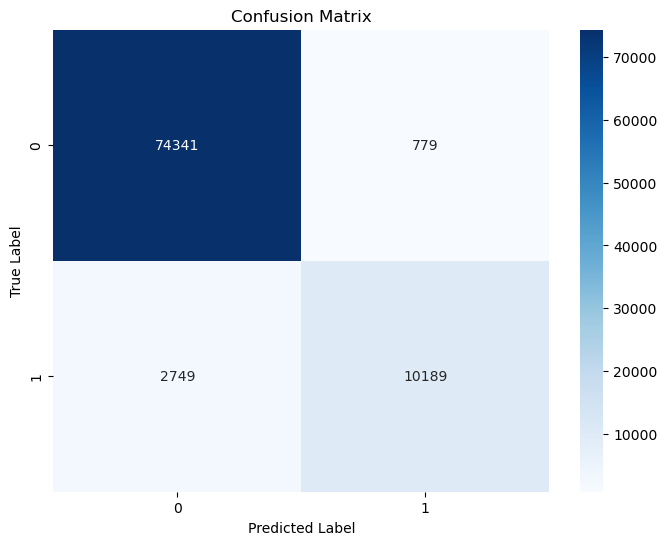

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     75120
           1       0.93      0.79      0.85     12938

    accuracy                           0.96     88058
   macro avg       0.95      0.89      0.91     88058
weighted avg       0.96      0.96      0.96     88058



In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 予測の実行
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # 閾値0.5でクラスに変換

# 混同行列の計算
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# 混同行列の表示
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 精度、適合率、再現率、F1スコアのレポート
print(classification_report(y_test, y_pred_classes))


In [ ]:
import tensorflow as tf

# TensorFlowのバージョンを確認
print("TensorFlow version:", tf.__version__)

# 利用可能なGPUリストを表示
print("Available GPU devices:", tf.config.list_physical_devices('GPU'))
